In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from mujoco_py import load_model_from_path, MjSim
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import os

from shared_utils.mujoco import n_step_forward
from shared_utils.general import get_project_root, gen_models_folder_path
from sklearn.metrics import mean_squared_error
from utils import add_joint_pos, add_musc_force
from elbow_muscles_eval.elbow_active_torque_exp import set_angular_range

In [25]:
def conduct_micro_stage(model, sim, joint_name, joint_index, new_range, n_step, pos_list, torque_list):
    set_angular_range(model, joint_index, new_range)
    n_step_forward(n_step, sim)

    add_joint_pos(sim.data, pos_list, joint_name)
    add_musc_force(sim.data, torque_list, joint_index)

## Evaluation with flexor and extensor together

In [26]:
# reference points: Holzbaur et al.
holz_angles = np.array([0, 25, 40, 50, 75, 100, 125])
holz_flex_torque = np.array([30., 45., 52., 67., 85., 100., 55.])
holz_ext_torque = np.array([-25., -40., -42., -40., -30., -29., -27.])

assert holz_angles.shape == holz_flex_torque.shape == holz_ext_torque.shape

# use polynomial fit
holz_flex_poly = np.poly1d(np.polyfit(holz_angles, holz_flex_torque, 5))
lin_holz_angles = np.linspace(holz_angles[0], holz_angles[-1], 100)
lin_holz_flex_torque = holz_flex_poly(lin_holz_angles)

holz_ext_poly = np.poly1d(np.polyfit(holz_angles, holz_ext_torque, 4))
lin_holz_ext_torque = holz_ext_poly(lin_holz_angles)

#### Amis experimental data
See Table 1 and 2 of the following reference:
<div class="csl-entry">Amis, A. A., Dowson, D., &#38; Wright, V. (1980). Analysis of elbow forces due to high-speed forearm movements. <i>Journal of Biomechanics</i>, <i>13</i>(10), 825–831. https://doi.org/10.1016/0021-9290(80)90170-0</div>

In [27]:
# reference points: Amis
amis_angles = np.array([0., 30., 60., 90., 120., 145.])
amis_flex_torque = np.array([53., 68., 76., 70., 51., 35.])
amis_ext_torque = -np.array([35., 41., 51., 52., 46., 42.])

assert amis_angles.shape == amis_flex_torque.shape == amis_ext_torque.shape

#### Buchanan experimental data
See Figure 3 of the following reference:

<div class="csl-entry">Buchanan, T. S., Delp, S. L., &#38; Solbeck, J. A. (1998). Muscular resistance to varus and valgus loads at the elbow. <i>Journal of Biomechanical Engineering</i>, <i>120</i>(5), 634–639. https://doi.org/10.1115/1.2834755</div>

In [28]:
buch_angles = np.arange(20., 140., 10.)

# mean 
buch_flex_torque = np.array([40., 44., 50., 56., 62., 69., 74., 78., 78., 75., 68., 57.
])
buch_ext_torque = np.array([-18., -23., -30., -35., -40., -45.,-48., -50., -51., -50., -47., -41.])

assert buch_angles.shape == buch_flex_torque.shape == buch_ext_torque.shape


# standard deviation:
buch_flex_torque_minus_sigma = np.array([27., 33., 39., 46., 52., 58., 63., 66., 66.5, 64., 55., 40.])
buch_flex_torque_sigma = buch_flex_torque-buch_flex_torque_minus_sigma

buch_ext_torque_plus_sigma = np.array([-10., -15., -16., -20., -25., -30., -34., -37., -40., -41., -41., -37.])
buch_ext_torque_sigma = buch_ext_torque_plus_sigma - buch_ext_torque

#### Simulated experiment

In [29]:
# load model and sim
# the file is generated via a xacro file located in muscle models
PATH_TO_MODEL = os.path.join(gen_models_folder_path(), "muscles", "eval_elbow_flex_ext.xml")
assert os.path.isfile(PATH_TO_MODEL), "Has the file been generated?"

model = load_model_from_path(PATH_TO_MODEL)

sim = MjSim(model)

# get index and names of flexors/extensors/joint
elbow_flexors_names = ["bic_b_avg", "bic_l",
                    "brachialis_avg", "brachiorad_avg"]
elbow_flexors_index = [model.actuator_name2id(
    muscle_name) for muscle_name in elbow_flexors_names]

elbow_extensors_names = ["tric_long_avg",
                        "tric_med_avg", "tric_lat_avg", "anconeus_avg"]
elbow_extensors_index = [model.actuator_name2id(
    muscle_name) for muscle_name in elbow_extensors_names]

elbow_joint_name = "el_x"
elbow_joint_index = model.joint_name2id(elbow_joint_name)

# parameters of the experiment
n_points = 20
micro_stage_steps = 150


# init array of measures
flexor_torques = []
flexion_joint_pos = []

extensor_torques = []
extension_joint_pos = []

# compute sequential ranges
init_lower_bound, init_upper_bound = model.jnt_range[elbow_joint_index]

# Hyp: flexion range = [0, 120] (verified in the original model)
assert np.isclose(init_lower_bound, 0.) and np.isclose(init_upper_bound, np.deg2rad(120.)), \
    "Check elbow angular range"

# define the tested angles
flex_angle_ub = np.arange(0., 130., 5.)

# Few checks:
# enough point should be evaluated
assert len(flex_angle_ub) > 20

# Amis and Buchanan points are in the evaluated points
# The last amis and buchanan points are excluded because out of the [0, 120] range
# TODO: Probably better implementation possible
assert np.all([np.isclose(np.full_like(flex_angle_ub, buch_angle), flex_angle_ub).any() for buch_angle in buch_angles[:-1]])
assert np.all([np.isclose(np.full_like(flex_angle_ub, amis_angle), flex_angle_ub).any() for amis_angle in amis_angles[:-1]])

# convert angles to rad (needed for Mujoco range)
flex_angle_ub = np.deg2rad(flex_angle_ub)
ext_angle_lb = np.flip(flex_angle_ub, 0)

# use angles to define the ranges
flex_angle_ranges = np.vstack((np.full_like(flex_angle_ub, init_lower_bound), flex_angle_ub)).T
ext_angle_ranges = np.vstack((ext_angle_lb, np.full_like(ext_angle_lb,init_upper_bound))).T

# set full flexor actuation
for flexor_index in elbow_flexors_index:
    sim.data.ctrl[flexor_index] = 1.

for angle_range in flex_angle_ranges:
    conduct_micro_stage(model, sim, elbow_joint_name, elbow_joint_index,
     angle_range, micro_stage_steps, flexion_joint_pos, flexor_torques)

# remove flexor actuation and set full extensor actuation
for flexor_index, extensor_index in zip(elbow_flexors_index, elbow_extensors_index):
    sim.data.ctrl[flexor_index] = 0.
    sim.data.ctrl[extensor_index] = 1.

for angle_range in ext_angle_ranges:
    conduct_micro_stage(model, sim, elbow_joint_name, elbow_joint_index,
     angle_range, micro_stage_steps, extension_joint_pos, extensor_torques)

#### Plot results

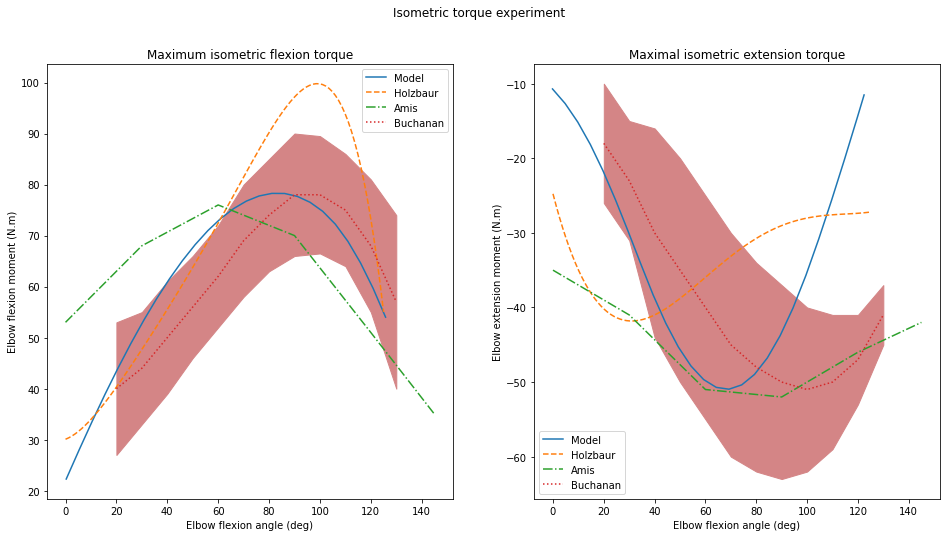

In [30]:
# color sequence
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
linestyles = ['-', '--', '-.', ':']
buch_uncertainty_color = "#d48586"

fig, axes = plt.subplots(1,2)
  
fig.set_size_inches(16, 8)
fig.suptitle('Isometric torque experiment')

# plot flexor maximal torque
axes[0].fill_between(buch_angles, buch_flex_torque - buch_flex_torque_sigma, buch_flex_torque + buch_flex_torque_sigma, color=buch_uncertainty_color)
axes[0].plot(np.rad2deg(flexion_joint_pos), flexor_torques, c=colors[0], label="Model", linestyle = linestyles[0])
axes[0].plot(lin_holz_angles, lin_holz_flex_torque, c=colors[1], label="Holzbaur", linestyle = linestyles[1])
axes[0].plot(amis_angles, amis_flex_torque, c=colors[2], label="Amis", linestyle = linestyles[2])
axes[0].plot(buch_angles, buch_flex_torque, c=colors[3], label="Buchanan", linestyle = linestyles[3])


axes[0].legend()

axes[0].set_xlabel("Elbow flexion angle (deg)")
axes[0].set_ylabel("Elbow flexion moment (N.m)")
axes[0].set_title("Maximum isometric flexion torque")

# plot extensor maximal torque
axes[1].fill_between(buch_angles, buch_ext_torque + buch_ext_torque_sigma, buch_ext_torque - buch_ext_torque_sigma, color=buch_uncertainty_color)
axes[1].plot(np.rad2deg(extension_joint_pos), extensor_torques, c=colors[0], label="Model", linestyle=linestyles[0])
axes[1].plot(lin_holz_angles, lin_holz_ext_torque, c=colors[1], label="Holzbaur", linestyle=linestyles[1])
axes[1].plot(amis_angles, amis_ext_torque, c=colors[2], label="Amis", linestyle = linestyles[2])
axes[1].plot(buch_angles, buch_ext_torque, c=colors[3], label="Buchanan", linestyle = linestyles[3])


axes[1].legend()

axes[1].set_xlabel("Elbow flexion angle (deg)")
axes[1].set_ylabel("Elbow extension moment (N.m)")
axes[1].set_title("Maximal isometric extension torque")


plt.show()

#### Eval loss

In [31]:
# convert to np array
flexion_joint_pos = np.array(flexion_joint_pos)
extension_joint_pos = np.array(extension_joint_pos)
flexor_torques = np.array(flexor_torques)
extensor_torques = np.array(extensor_torques)


# eval the correctness of the experiment
flex_angle_ub_orig = np.rad2deg(flex_angle_ub)

# find index of comparison points
amis_comp_index = np.ravel([np.where(np.isclose(amis_angle, flex_angle_ub_orig)) for amis_angle in amis_angles[:-1]]).astype(np.int16)
buch_comp_index = np.ravel([np.where(np.isclose(buch_angle, flex_angle_ub_orig)) for buch_angle in buch_angles[:-1]]).astype(np.int16)

# extract experimental angles
exp_flex_amis_angles = np.rad2deg(flexion_joint_pos[amis_comp_index])
exp_ext_amis_angles = np.rad2deg(extension_joint_pos[len(extension_joint_pos)-1 - amis_comp_index])

exp_flex_buch_angles = np.rad2deg(flexion_joint_pos[buch_comp_index])
exp_ext_buch_angles = np.rad2deg(extension_joint_pos[len(extension_joint_pos)-1 - buch_comp_index])

# measure angle error
print(f"{'Amis flexion angle RMSE:':<35}{mean_squared_error(exp_flex_amis_angles, amis_angles[:-1], squared=False)} deg")
print(f"{'Amis extension angle RMSE:':<35}{mean_squared_error(exp_ext_amis_angles, amis_angles[:-1], squared=False)} deg\n")

print(f"{'Buchanan flexion angle RMSE:':<35}{mean_squared_error(exp_flex_buch_angles, buch_angles[:-1], squared=False)} deg")
print(f"{'Buchanan extension angle RMSE:':<35}{mean_squared_error(exp_ext_buch_angles, buch_angles[:-1], squared=False)} deg\n")

# measure 
exp_flex_amis_torque = flexor_torques[amis_comp_index]
exp_flex_buch_torque = flexor_torques[buch_comp_index]
exp_ext_amis_torque = extensor_torques[len(extensor_torques)-1 - amis_comp_index]
exp_ext_buch_torque = extensor_torques[len(extensor_torques)-1 - buch_comp_index]

print(f"{'Amis flexion moment RMSE:':<35}{mean_squared_error(exp_flex_amis_torque, amis_flex_torque[:-1], squared=False)} N.m")
print(f"{'Amis extension moment RMSE:':<35}{mean_squared_error(exp_ext_amis_torque, amis_ext_torque[:-1], squared=False)} N.m\n")

print(f"{'Buchanan flexion moment RMSE:':<35}{mean_squared_error(exp_flex_buch_torque, buch_flex_torque[:-1], squared=False)} N.m")
print(f"{'Buchanan extension moment RMSE:':<35}{mean_squared_error(exp_ext_buch_torque, buch_ext_torque[:-1], squared=False)} N.m\n")

Amis flexion angle RMSE:           0.8512966633152961 deg
Amis extension angle RMSE:         0.48517401799211507 deg

Buchanan flexion angle RMSE:       0.9541613434085507 deg
Buchanan extension angle RMSE:     0.5572564924481096 deg

Amis flexion moment RMSE:          16.11646235014058 N.m
Amis extension moment RMSE:        18.86398545834603 N.m

Buchanan flexion moment RMSE:      8.035484322530044 N.m
Buchanan extension moment RMSE:    14.425165754780627 N.m



NB:
- The angular error is bigger for flexion than for extension: the reason is that the flexors are more powerful than the extensors
- The level of error is acceptable if one considers the uncertainties of Buchanan/Amis measurements

#### Save a tikz schematics

In [32]:
SAVE_TIKZ_PLOT = False
if(SAVE_TIKZ_PLOT):
    generated_pgfs_dir = os.path.join(get_project_root(), "bin", "pgf_plots")
    assert os.path.isdir(generated_pgfs_dir)

    # color sequence
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', '-.', ':']

    # fig, axes = plt.subplots(1,2)
    

    # plot flexor maximal torque
    plt.figure()
    plt.plot(np.rad2deg(flexion_joint_pos), flexor_torques, c=colors[0], label="Model", linestyle = linestyles[0])
    plt.plot(lin_holz_angles, lin_holz_flex_torque, c=colors[1], label="Holzbaur", linestyle = linestyles[1])
    plt.plot(amis_angles, amis_flex_torque, c=colors[2], label="Amis", linestyle = linestyles[2])
    plt.plot(buch_angles, buch_flex_torque, c=colors[3], label="Buchanan", linestyle=linestyles[3])


    plt.legend()

    plt.xlabel("Elbow flexion angle (deg)")
    plt.ylabel("Elbow flexion moment (N.m)")
    plt.title("Maximum isometric flexion torque")
    tikzplotlib.save(os.path.join(generated_pgfs_dir, "elbow_flexion.pgf"))



    # plot extensor maximal torque
    plt.figure()
    plt.plot(np.rad2deg(extension_joint_pos), extensor_torques, c=colors[0], label="Model", linestyle=linestyles[0])
    plt.plot(lin_holz_angles, lin_holz_ext_torque, c=colors[1], label="Holzbaur", linestyle=linestyles[1])
    plt.plot(amis_angles, amis_ext_torque, c=colors[2], label="Amis", linestyle = linestyles[2])
    plt.plot(buch_angles, buch_ext_torque, c=colors[3], label="Buchanan", linestyle=linestyles[3])

    plt.legend()

    plt.xlabel("Elbow flexion angle (deg)")
    plt.ylabel("Elbow extension moment (N.m)")
    plt.title("Maximal isometric extension torque")
    tikzplotlib.save(os.path.join(generated_pgfs_dir, "elbow_extension.pgf"))
